# Audio sample

* Read audio samples with pyaudio and plot some samples
* Train a softmax classifier with wav files

In [1]:
import pyaudio
import glob
import matplotlib.pyplot as plt
import numpy as np
import wave

In [2]:
FORMAT = pyaudio.paInt16                # We use 16bit format per sample
CHANNELS = 2
RATE = 44100
CHUNK = 1024                            # 1024 bytes of data red from a buffer
RECORD_SECONDS = 2
FILENAME = "./me/001.wav"

audio = pyaudio.PyAudio()
wf = wave.open(FILENAME, 'rb')

data = wf.readframes(CHUNK)

(2048,)


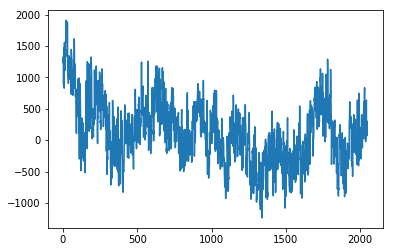

In [3]:
# plot one sample
fig = plt.figure()
s = fig.add_subplot(111)
amplitude = np.frombuffer(data, np.int16)
print(amplitude.shape)
s.plot(amplitude)

# Collect Training samples

In [4]:
# Read all positive samples
lf = sorted(list(glob.glob("me/*.wav*")))
X = np.array([])
Y = list()
Y_gender = list()
for k in range(len(lf)):
    wf = wave.open(lf[k], 'rb')
    data = wf.readframes(CHUNK)
    data_np = np.frombuffer(data, np.int16)
    if k == 0:
        X = data_np.copy()
        Y.append(1)
        Y_gender.append(1)
    else:
        X = np.row_stack([X, data_np])
        Y.append(1)
        Y_gender.append(1)

In [5]:
# Read all negative samples men
lf = sorted(list(glob.glob("not_me_men/*.wav*")))
for k in range(len(lf)):
    wf = wave.open(lf[k], 'rb')
    data = wf.readframes(CHUNK)
    data_np = np.frombuffer(data, np.int16)
    X = np.row_stack([X, data_np])
    Y.append(0)
    Y_gender.append(1)

In [6]:
# Read all negative samples women
lf = sorted(list(glob.glob("not_me_women/*.wav*")))
for k in range(len(lf)):
    wf = wave.open(lf[k], 'rb')
    data = wf.readframes(CHUNK)
    data_np = np.frombuffer(data, np.int16)
    X = np.row_stack([X, data_np])
    Y.append(0)
    Y_gender.append(0)

In [7]:
# print dataset shape
print(X.shape)

(50, 2048)


In [8]:
# subtract mean
X = X.astype(np.float64)
val_mean = np.mean(X)
X -= val_mean
X = np.hstack([X, np.ones([X.shape[0], 1])])

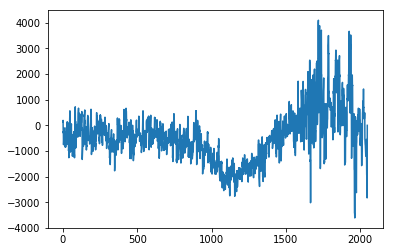

In [9]:
plt.plot(X[20])

In [10]:
print(X.shape)
print(X[0][-4:])

(50, 2049)
[658.94174805 710.94174805 794.94174805   1.        ]


# Collect validation samples

In [11]:
# Read all positive samples in validation
lf = sorted(list(glob.glob("val_me/*.wav*")))
X_val = np.array([])
Y_val = list()
Y_gender_val = list()
for k in range(len(lf)):
    wf = wave.open(lf[k], 'rb')
    data = wf.readframes(CHUNK)
    data_np = np.frombuffer(data, np.int16)
    if k == 0:
        X_val = data_np.copy()
        Y_val.append(1)
        Y_gender_val.append(1)
    else:
        X_val = np.row_stack([X_val, data_np])
        Y_val.append(1)
        Y_gender_val.append(1)

In [12]:
# Read negative samples in validation
lf = sorted(list(glob.glob("not_me_men/*.wav*")))
for k in range(len(lf)):
    wf = wave.open(lf[k], 'rb')
    data = wf.readframes(CHUNK)
    data_np = np.frombuffer(data, np.int16)
    X_val = np.row_stack([X_val, data_np])
    Y_val.append(0)
    Y_gender_val.append(1)

In [13]:
# Read all negative samples women
lf = sorted(list(glob.glob("not_me_women/*.wav*")))
for k in range(len(lf)):
    wf = wave.open(lf[k], 'rb')
    data = wf.readframes(CHUNK)
    data_np = np.frombuffer(data, np.int16)
    X_val = np.row_stack([X_val, data_np])
    Y_val.append(0)
    Y_gender_val.append(0)

In [14]:
# subtract mean
X_val = X_val.astype(np.float64)
X_val -= val_mean
X_val = np.hstack([X_val, np.ones([X_val.shape[0], 1])])

(40, 2049)


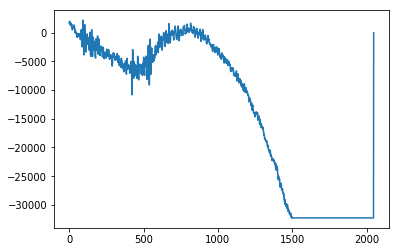

In [15]:
plt.plot(X_val[0])
print(X_val.shape)

# Training

In [16]:
class customSoftmaxClassifier(object):
    def __init__(self, X, Y, X_val=None, Y_val=None, lr=1e-1, reg=0, 
                 num_iter=2500, batch_size=100, scale_init=1e-3):
        self.x_train = X
        self.y_train = Y
        self.x_val = X_val
        self.y_val = Y_val
        self.lr = lr
        self.reg = reg
        self.num_iter = num_iter
        self.batch_size = batch_size
        self.loss_history = list()
        self.train_acc = list()
        self.loss_val_history = list()
        self.val_acc = list()
        self.W = np.random.randn(X.shape[1], np.max(Y) + 1) * scale_init
    def softmax_loss_vectorization(self, W, X, y, reg):
        """
        Softmax loss function

        D: number of features at the input vector
        C: number of classes in the dataset
        N: number of samples to operate on minibatches

        Inputs
         W: A numpy array of shape (D, C) containing weights.
         X: A numpy array of shape (N, D) containing a minibatch of data.
         y: A numpy array of shape (N,) containing training labels; y[i] = c means
        that X[i] has label c, where 0 <= c < C.
         reg: (float) regularization strength

        Output:
         loss: the total loss as single float
         dW: gradients with respect to weights W; an array of same shape as W
        """
        loss = 0
        dW = np.zeros(W.shape)

        ##########################################################################
        # TODO: compute loss and gradients for this function, take into account  #
        # regularization in the loss and the gradients                           #
        # START                                                                  #
        ##########################################################################

        num_train = X.shape[0]
        num_classes = np.max(y) + 1
        y_one_hot = np.zeros([num_train, num_classes])
        y_one_hot[np.arange(num_train), y] = 1

        dot_xw = np.dot(X, W)
        # numerical stability
        max_score = np.max(dot_xw, axis=1).reshape(-1, 1)
        stabilized_xw = dot_xw - max_score
        exp_stabilized_xw = np.exp(stabilized_xw)
        matrix_q = exp_stabilized_xw/np.sum(exp_stabilized_xw, axis=1).reshape(-1, 1)

        # compute loss
        vec_exp = exp_stabilized_xw[np.arange(num_train), y].reshape(-1, 1)
        sum_exp = np.sum(exp_stabilized_xw, axis=1).reshape(-1, 1)

        loss = (-1/num_train)*np.sum(np.log(vec_exp/sum_exp)) + reg*np.sum(W*W)

        # compute
        xmat = np.zeros_like(dot_xw)
        xmat[np.arange(num_train), y] = -1
        grad = (1/num_train)*(np.dot(X.T, xmat) + np.dot(X.T, matrix_q)) + 2*reg*W

        ##########################################################################
        # END                                                                    #
        ##########################################################################
        return loss, grad
    def train(self):
        num_train = self.x_train.shape[0]
        for k in range(self.num_iter):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Implement SGD (stochastic gradient descent)                           #
            # Hint: look for the function in numpy np.random.choice                 #
            #########################################################################
            # randomly sample some samples
            #sample_indices = np.random.choice(np.arange(num_train), self.batch_size)
            # x_batch = self.x_train[sample_indices]
            # y_batch = self.y_train[sample_indices]

            # evaluate loss and gradient
            loss, grad = self.softmax_loss_vectorization(self.W, self.x_train, self.y_train, self.reg)
            self.loss_history.append(loss)
            pred = self.predict(self.x_train)
            self.train_acc.append(np.mean(pred == self.y_train))
            if self.x_val is not None:
                l, _  = self.softmax_loss_vectorization(self.W, self.x_val, self.y_val, self.reg)
                self.loss_val_history.append(l)
                pred = self.predict(self.x_val)
                self.val_acc.append(np.mean(pred == self.y_val))
            

            # perform parameter update
            self.W = self.W - self.lr * grad
            #########################################################################
            #  END                                                                  #               
            #########################################################################
    def predict(self, X):
        # TODO: Implement prediction function for svm
        #   X: input array with shape (N_test x D)
        return np.argmax(np.dot(X, self.W), axis=1)
    def compute_prob(self, X):
        # return probabilities from a sample
        #   X: input array with shape (N_test x D)
        dot_xw = np.dot(X, self.W)
        max_score = np.max(dot_xw, axis=1).reshape(-1, 1)
        stabilized_xw = dot_xw - max_score
        exp_stabilized_xw = np.exp(stabilized_xw)
        matrix_q = exp_stabilized_xw/np.sum(exp_stabilized_xw, axis=1).reshape(-1, 1)
        return matrix_q
    def get_loss(self):
        return self.loss_history
    def get_loss_val(self):
        return self.loss_val_history
    def get_train_acc(self):
        return self.train_acc
    def get_val_acc(self):
        return self.val_acc
    def getW(self):
        return self.W

In [17]:
softmax = customSoftmaxClassifier(X, Y, X_val=X_val, Y_val=Y_val, lr=1e-8, scale_init=1e-12, num_iter=200)

In [18]:
softmax.train()

/home/darial/virtual_env/ml_lecture_env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log


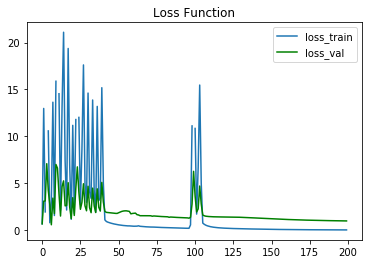

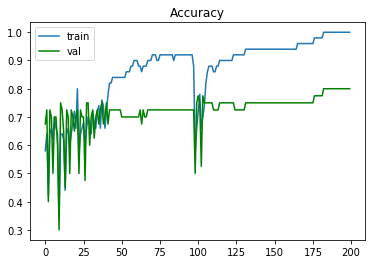

In [19]:
plt.figure()
plt.plot(softmax.get_loss())
plt.plot(softmax.get_loss_val(), color='g')
plt.legend(('loss_train','loss_val'))
plt.title('Loss Function')
plt.show()
#print(softmax.get_loss_val())

plt.figure()
plt.plot(softmax.get_train_acc())
plt.plot(softmax.get_val_acc(), color='g')
plt.legend(('train','val'))
plt.title('Accuracy')
plt.show()

In [20]:
print("train accuracy", softmax.get_train_acc()[-1])
print("val accuracy", softmax.get_val_acc()[-1])

train accuracy 1.0
val accuracy 0.8


# Test some samples

In [21]:
file_val = "val_me/001.wav"
file_val2 = "val_not_me_women/003.wav"
wf = wave.open(file_val2, 'rb')
data = wf.readframes(CHUNK)
new_x = np.frombuffer(data, np.int16).astype(np.float64) - val_mean
new_x = np.hstack([new_x.reshape(1, -1), np.ones([1,1])])
print(new_x.shape)

(1, 2049)


In [22]:
prob = softmax.compute_prob(new_x.reshape(1, -1))
class_pred = np.argmax(prob, axis=1)
if class_pred[0] == 0:
    print("not me")
else:
    print("yep its me")
print(prob[0][1])

not me
6.758656285596999e-51


# Save model

Save classifier as pickle object

In [30]:
import pickle

def save_object(file_path, python_obj):
    """Save object in a file"""
    with open(file_path, 'wb') as f:
        pickle.dump(python_obj, f)


def load_object(file_path):
    """Load file in a object"""
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [31]:
model = dict()
model["model"] = softmax
model["mean"] = val_mean
save_object("classifier.pkl", model)